In [168]:
import pickle
import numpy as np
from sklearn.preprocessing import RobustScaler,MinMaxScaler
X_ppg,X_qual,X_acc,y_rr, y_respiration,y_inspiration,y_expiration,groups = pickle.load(open('../../affect-recognition/data/tabular_data.p','rb'))
X_ppg = X_ppg.reshape(-1,512,1)
# X_ppg = np.array([MinMaxScaler().fit_transform(a) for a in X_ppg])
y_rr = 60000/(1000*y_rr)
print(X_ppg.shape)

(10841, 512, 1)


In [169]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tf
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=len(np.unique(groups)))
train,test = list(gkf.split(X_ppg,groups=groups))[1]
X_ppg_train,X_ppg_test = X_ppg[train],X_ppg[test]
X_qual_train,X_qual_test = X_qual[train],X_qual[test]
y_rr_train,y_rr_test = y_rr[train],y_rr[test]

In [198]:
def get_base_GRU(timesteps_ppg=512,input_dim_ppg=1,first_dim=60,optimizer='adam',loss='mae'):
    inputs = Input(shape=(timesteps_ppg, input_dim_ppg))
    encoded = Bidirectional(GRU(first_dim,return_sequences=True,activation='sigmoid',go_backwards=True))(inputs)
    dense_layer = TimeDistributed(Dense(1,activation='relu'))(encoded)
    flattened = Flatten()(dense_layer)
    output = Dense(30,activation='relu')(flattened)
    output = Dense(1,activation='relu')(output)
    sequence_autoencoder = Model(inputs=[inputs], outputs=[output])
    sequence_autoencoder.compile(optimizer=optimizer,loss=loss)
    return sequence_autoencoder

def get_base_autoencoder(timesteps_ppg=512,input_dim_ppg=1,first_dim=60,optimizer='adam',loss='mae'):
    inputs = Input(shape=(timesteps_ppg, input_dim_ppg))
    encoded = Reshape((timesteps_ppg,))(inputs)
    encoded = Dense(timesteps_ppg//2,activation='sigmoid')(encoded)
#     encoded = Dense(timesteps_ppg//4,activation=0'selu')(encoded)
    encoded = Dense(timesteps_ppg//14,activation='selu')(encoded)
#     encoded = Dense(timesteps_ppg//4,activation='selu')(encoded)
#     encoded = Dense(timesteps_ppg//2,activation='selu')(encoded)
    encoded = Dense(timesteps_ppg,activation='linear')(encoded)
#     Bidirectional(LSTM(first_dim,return_sequences=True,activation='sigmoid',go_backwards=True))(inputs)
#     dense_layer = TimeDistributed(Dense(1,activation='sigmoid'))(encoded)
#     flattened = Flatten()(dense_layer)
#     output = Dense(30,activation='sigmoid')(flattened)
#     output = Dense(timesteps_ppg,activation='sigmoid')(output)
    encoded = Reshape((timesteps_ppg, input_dim_ppg))(encoded)
#     output = Bidirectional(LSTM(first_dim,return_sequences=True,activation='sigmoid',go_backwards=True))(output)
#     output = TimeDistributed(Dense(1,activation='sigmoid'))(output)
    sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded])
    sequence_autoencoder.compile(optimizer=optimizer,loss=loss)
    return sequence_autoencoder


timesteps_ppg = 512
input_dim_ppg = 1
sequence_autoencoder = get_base_autoencoder(timesteps_ppg=timesteps_ppg,input_dim_ppg=input_dim_ppg,
                                    first_dim=60,optimizer='adam',loss='logcosh')
sequence_autoencoder.summary()

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (None, 512, 1)            0         
_________________________________________________________________
reshape_58 (Reshape)         (None, 512)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_162 (Dense)            (None, 36)                9252      
_________________________________________________________________
dense_163 (Dense)            (None, 512)               18944     
_________________________________________________________________
reshape_59 (Reshape)         (None, 512, 1)            0         
Total params: 159,524
Trainable params: 159,524
Non-trainable params: 0
____________________________________________________

In [217]:
filepath = '../../affect-recognition/data/autoencoder.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_ppg_train, X_ppg_train,
                epochs=400,
                batch_size=200,
                shuffle=True,
                validation_split=.2,callbacks=callbacks_list)

Train on 8024 samples, validate on 2006 samples
Epoch 1/400
8024/8024 [==============================] - 0s 51us/step - loss: 23.4806 - val_loss: 24.3250

Epoch 00001: val_loss improved from inf to 24.32501, saving model to ../../affect-recognition/data/autoencoder.h5
Epoch 2/400
8024/8024 [==============================] - 0s 51us/step - loss: 23.4329 - val_loss: 24.3110

Epoch 00002: val_loss improved from 24.32501 to 24.31103, saving model to ../../affect-recognition/data/autoencoder.h5
Epoch 3/400
8024/8024 [==============================] - 0s 51us/step - loss: 23.4025 - val_loss: 24.3013

Epoch 00003: val_loss improved from 24.31103 to 24.30132, saving model to ../../affect-recognition/data/autoencoder.h5
Epoch 4/400
8024/8024 [==============================] - 0s 51us/step - loss: 23.3773 - val_loss: 24.3067

Epoch 00004: val_loss did not improve from 24.30132
Epoch 5/400
8024/8024 [==============================] - 0s 51us/step - loss: 23.3620 - val_loss: 24.3162

Epoch 00005: 

8024/8024 [==============================] - 0s 50us/step - loss: 23.1600 - val_loss: 24.2667

Epoch 00047: val_loss did not improve from 24.24312
Epoch 48/400
8024/8024 [==============================] - 0s 51us/step - loss: 23.1573 - val_loss: 24.2647

Epoch 00048: val_loss did not improve from 24.24312
Epoch 49/400
8024/8024 [==============================] - 0s 51us/step - loss: 23.1532 - val_loss: 24.2576

Epoch 00049: val_loss did not improve from 24.24312
Epoch 50/400
8024/8024 [==============================] - 0s 51us/step - loss: 23.1461 - val_loss: 24.2689

Epoch 00050: val_loss did not improve from 24.24312
Epoch 51/400
8024/8024 [==============================] - 0s 51us/step - loss: 23.1559 - val_loss: 24.2657

Epoch 00051: val_loss did not improve from 24.24312
Epoch 52/400
8024/8024 [==============================] - 0s 50us/step - loss: 23.1493 - val_loss: 24.2527

Epoch 00052: val_loss did not improve from 24.24312
Epoch 53/400
8024/8024 [=============================

In [218]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [219]:
X_ppg_pred = sequence_autoencoder.predict(X_ppg_test)

<IPython.core.display.Javascript object>


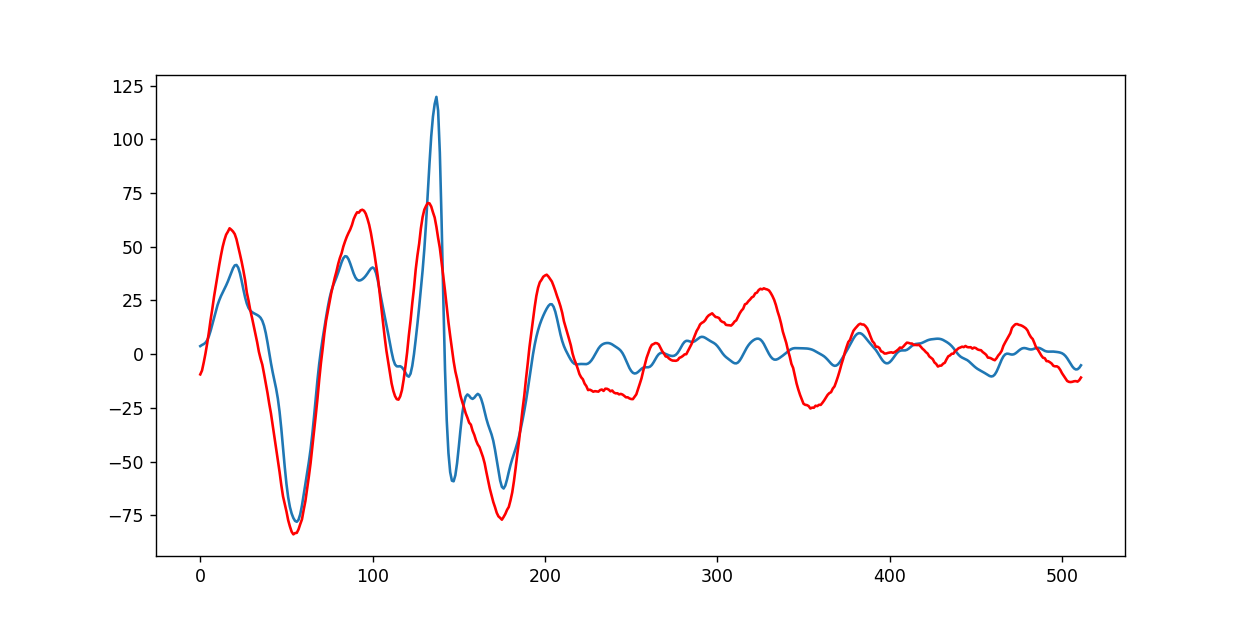

In [220]:
plt.figure(figsize=(10,5))
plt.plot(X_ppg_test[400])
plt.plot(X_ppg_pred[400],'r')
plt.show()

In [8]:
y_rr_pred = sequence_autoencoder.predict(X_ppg_test)

<IPython.core.display.Javascript object>


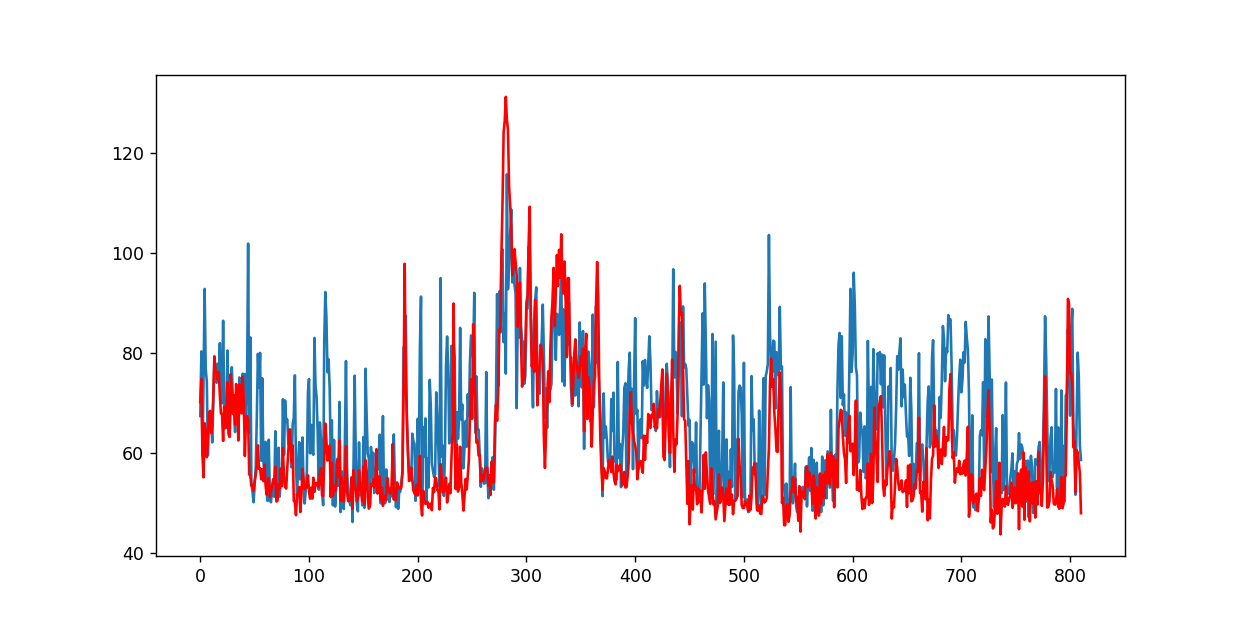

In [9]:
plt.figure(figsize=(10,5))
plt.plot(y_rr_pred)
plt.plot(y_rr_test,'r')

In [10]:
differences = np.abs(y_rr_pred-y_rr_test)

In [11]:
relative_powers = [np.mean(a[:,-1]) for a in X_qual_test]

<IPython.core.display.Javascript object>


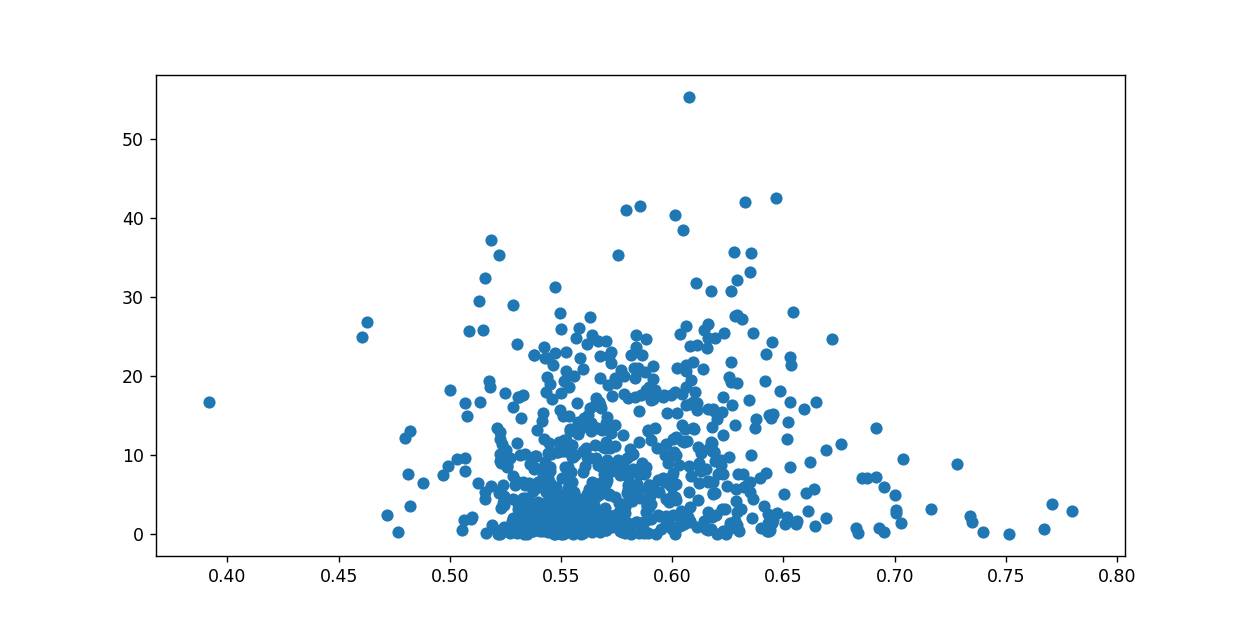

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(relative_powers,differences)
plt.show()

In [14]:
np.mean(differences)

8.563876893290832